In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import os
import time
import joblib

# Your dataset path
csv_path = "dataset/both_serv.csv"
# csv_path = "dataset/only_int.csv"
# csv_path = "dataset/only_ph.csv"

# Load dataset
df = pd.read_csv(csv_path)
num_columns = df.shape[1]
print("Number of columns:", num_columns)
# Extract the base filename without extension
dataset_name = os.path.splitext(os.path.basename(csv_path))[0]

Number of columns: 24


In [42]:
# Separate features (X) and target label (y)
X = df.drop(columns='Churn')
y = df['Churn']

In [43]:
# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Start timing
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=500,           # Large number so early stopping can cut it short
    learning_rate=0.01,
    max_depth=10,
    subsample=0.6,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    early_stopping_rounds=50,   # Stop if no improvement for 50 rounds
    verbose=True                 # Print progress each round
)

# End timing
train_time = time.time() - start_time
print(f"\n✅ Model trained in {train_time:.2f} seconds")



✅ Model trained in 4.14 seconds


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       281
           1       0.23      0.65      0.34        23

    accuracy                           0.81       304
   macro avg       0.60      0.74      0.61       304
weighted avg       0.91      0.81      0.84       304

Confusion Matrix:


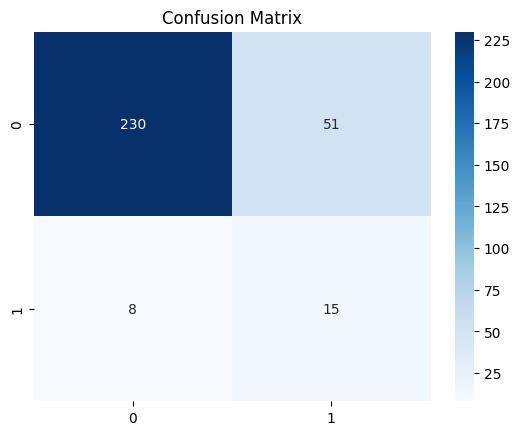

ROC AUC Score: 0.8001
Model saved to: models/rf/20250704_220558_only_ph_rf_model_v2.pkl


In [ ]:
# Predictions
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

# Log file name (create one log per run, timestamped)
log_file = f"models/xgb/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{dataset_name}_xgb_log_v1.txt"

# Gather key info
log_data = {
    "timestamp": datetime.now().isoformat(),
    "model": "XGBoost",
    "params": xgb_model.get_params(),
    "roc_auc": roc_auc_score(y_test, y_prob),
    "classification_report": classification_report(y_test, y_pred, output_dict=True)
}

# Write to file
with open(log_file, "w") as f:
    f.write(json.dumps(log_data, indent=4))

model_file = f"models/xgb/{datetime.now().strftime('%Y%m%d_%H%M%S')}_{dataset_name}_xgb_model_v1.pkl"
joblib.dump(xgb_model, model_file)

print(f"Model saved to: {model_file}")

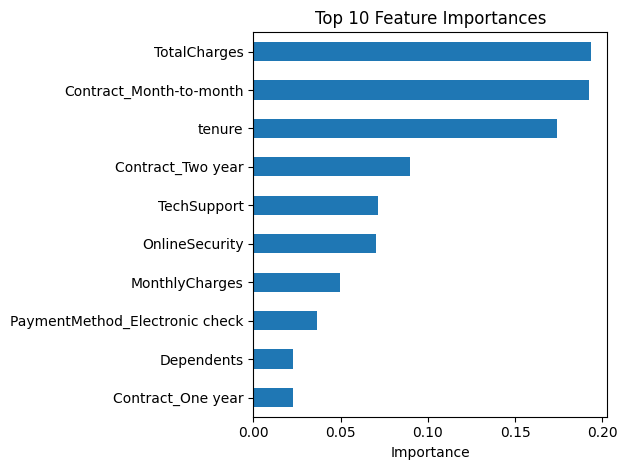

In [ ]:
# Feature importance
importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
importances.sort_values().tail(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
